# Análisis Exploratorio de Datos

## Carga de paquetes 

In [1]:
import pandas as pd
import numpy  as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import streamlit as st
import plotly.express as px
from datetime import datetime
from utils import *



In [ ]:
# Se hace la conexión local de la BBDD
conn = sqlite3.connect(r"database.sqlite")
cur = conn.cursor()

# Inspeccion de entidades
consulta_ntablas = "SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;"

print("Entidades en la base de datos:")
entidades = pd.read_sql_query(sql = consulta_ntablas, con = conn)
entidades

Entidades en la base de datos:


name
0   Atributos_Jugador
1             Country
2              Equipo
3           Jugadores
4              League
5                Liga
6               Match
7             Partido
8              Player
9   Player_Attributes
10               Team
11    Team_Attributes
12    sqlite_sequence

## Denormalización de la BBDD

En este paso se aplicó el enfoque de denormalización propuesto por Ralph Kimball, con el propósito de optimizar el acceso y la velocidad de consulta de los datos. A diferencia de los modelos altamente normalizados, donde la información se distribuye en múltiples tablas para evitar redundancias, la denormalización busca crear estructuras más simples y directas que faciliten el análisis y reduzcan la necesidad de realizar uniones (joins) complejas. Este enfoque resulta especialmente útil en contextos de análisis de datos o inteligencia de negocio, donde la eficiencia en las consultas y la claridad en la estructura de la base de datos son prioritarias.

En el código desarrollado, se transformó las principales tablas de la base de datos original en versiones más accesibles y consolidadas. Por ejemplo, se creó la tabla Liga a partir de la combinación de las tablas League y Country, integrando el nombre del país directamente en la estructura de la liga. Además, se generaron las tablas Jugadores, Atributos_Jugador, Partido y Equipo, seleccionando únicamente los campos más relevantes y aplicando transformaciones para estandarizar los tipos de datos, como la conversión de fechas. De esta manera, se obtuvo un modelo más ágil, con menor complejidad relacional y preparado para realizar análisis de manera más eficiente.


In [ ]:
cur.execute("""
CREATE TABLE IF NOT EXISTS Jugadores AS
SELECT player_api_id, player_name, birthday, height, weight FROM Player;
""")
cur.execute("UPDATE Jugadores SET birthday = DATE(birthday);")
conn.commit()


cur.execute("""
CREATE TABLE IF NOT EXISTS Liga AS
SELECT
    T2.id AS id_country_league,
    T2.name AS name_country,
    T1.name AS name_league
FROM
    League AS T1
INNER JOIN
    Country AS T2 ON T1.country_id = T2.id;
""")
conn.commit()


cur.execute("""
CREATE TABLE IF NOT EXISTS Partido AS
SELECT match_api_id, league_id, season, date, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11
FROM Match;
""")
cur.execute("UPDATE Partido SET date = DATE(date);")
conn.commit()


cur.execute("""
CREATE TABLE IF NOT EXISTS Atributos_Jugador AS
SELECT
    player_api_id,
    date,
    overall_rating,
    potential,
    preferred_foot,
    acceleration,
    sprint_speed,
    dribbling,
    agility,
    ball_control,
    long_shots,
    shot_power,
    penalties,
    volleys,
    gk_diving,
    gk_handling,
    gk_kicking,
    gk_positioning,
    gk_reflexes
FROM
    Player_Attributes;
""")
cur.execute("UPDATE Atributos_Jugador SET date = DATE(date);")
conn.commit()


cur.execute("""
CREATE TABLE IF NOT EXISTS Equipo AS
SELECT team_api_id, team_short_name, team_long_name
FROM Team;
""")
conn.commit()


conn.close()

## Creación de inputs Parquet

Debido a que la base de datos original en formato SQLite supera los 100 MB, no es posible alojarla directamente en GitHub, ya que la plataforma impone un límite de tamaño para los archivos individuales del repositorio.

Por esta razón, se decidió migrar las entidades de la base de datos denormalizada a archivos Parquet, un formato columnar optimizado para almacenamiento y procesamiento de datos. Esta conversión permite conservar la estructura y la información de las tablas originales, pero con un tamaño de archivo significativamente menor y una lectura más eficiente desde Python utilizando pandas.

Estas tablas serán manejadas en la capa “bronce” ya que tuvieron pocas modificaciones y servirán como insumo base para las tablas  que estarán en Silver o Gold para realizar todas las salidas pertinentes.

De esta manera, los archivos Parquet pueden ser versionados y almacenados en el repositorio sin inconvenientes, garantizando al mismo tiempo un acceso rápido a los datos durante la ejecución de la aplicación web o en las pruebas técnicas.

In [ ]:
conn = sqlite3.connect("database.sqlite")

tablas = ["df_df_df_df_df_df_df_df_jugadores", "Atributos_Jugador", "Partido", "Equipo", "Liga"]
for tabla in tablas:
    df = pd.read_sql(f"SELECT * FROM {tabla}", conn)
    df.to_parquet(f"data/bronze/{tabla}.parquet", index=False)

conn.close()

## Lectura de archivos Parquet

In [2]:
data = cargar_archivos_parquet("data/bronze")

Se cargaron correctamente 5 archivos Parquet.


In [3]:
# Lecturas de las tablas Bronze

df_jugadores          = data['jugadores']
df_atributo_jugadores = data['atributos_jugador']
df_equipo             = data['equipo']
df_liga               = data['liga']
df_partido            = data['partido']

## Estandarización de los Datos (Capa Silver)

En esta etapa del proceso se llevó a cabo la creación de la capa Silver, cuyo objetivo principal es transformar y estandarizar las tablas originales provenientes de la capa Bronze. El propósito de esta fase es asegurar la consistencia, legibilidad y homogeneidad de los datos, permitiendo que las entidades estén listas para el análisis y el modelado posterior.

Para lograrlo, se diseñó un proceso de renombrado sistemático de columnas, con el fin de unificar los nombres de los campos y adoptar una convención uniforme en español, empleando minúsculas y guiones bajos para facilitar su manipulación en Python. Esta estandarización se aplicó a las principales entidades del modelo jugadores, equipos, atributos de jugadores, ligas y partidos, garantizando coherencia entre las distintas fuentes.

Además, se efectuaron transformaciones específicas sobre los campos más relevantes:

* Conversión del peso de los jugadores de libras a kilogramos para mantener la unidad métrica.

* Normalización de las fechas a un formato estándar (%d-%m-%y), asegurando compatibilidad temporal entre tablas.

* Traducción de valores categóricos al español, como los nombres de países, ligas y el pie preferido de los jugadores, promoviendo la localización lingüística del conjunto de datos.

* Eliminación de registros con valores nulos en la tabla de partidos, garantizando la integridad de las relaciones entre entidades.


In [4]:
def renombrar_columnas(df, mapeo):
    return df.rename(columns=mapeo)

mapeo_jugadores = {
    'player_api_id': 'id_jugador', 
    'player_name': 'nombre_jugador', 
    'birthday': 'fecha_nacimiento', 
    'height': 'altura', 
    'weight': 'peso'
}
mapeo_atributos = {
    'player_api_id': 'id_jugador', 
    'date': "fecha_temporada", 
    'overall_rating': 'calificacion_general', 
    'potential': 'potencial', 
    'preferred_foot': 'pie_preferido',
    'acceleration': 'aceleracion', 
    'sprint_speed': 'velocidad_sprint', 
    'dribbling': 'regate', 
    'agility': 'agilidad', 
    'ball_control': 'control_balon',
    'long_shots': 'tiros_largos', 
    'shot_power': 'potencia_tiro', 
    'penalties': 'penaltis', 
    'volleys': 'voleas',
    'gk_diving': 'portero_salto', 
    'gk_handling': 'portero_manejo', 
    'gk_kicking': 'portero_patada', 
    'gk_positioning': 'portero_posicionamiento', 
    'gk_reflexes': 'portero_reflejos'
}
mapeo_equipo = {
    'team_api_id': 'id_equipo', 
    'team_short_name': 'nombre_corto_equipo', 
    'team_long_name': 'nombre_largo_equipo'
}
mapeo_liga = {
    'id_country_league': 'id_pais_liga', 
    'name_country': 'nombre_pais', 
    'name_league': 'nombre_liga'
}
mapeo_partido = {
    'match_api_id': 'id_partido', 
    'league_id': 'id_pais_liga',
    'season': 'temporada',
    'date': 'fecha_partido',
    'home_team_api_id': 'id_equipo_local',
    'away_team_api_id': 'id_equipo_visitante',
    'home_team_goal': 'goles_local',
    'away_team_goal': 'goles_visitante',
    'home_player_1' : 'jugador_local_1',
    'home_player_2' : 'jugador_local_2',
    'home_player_3' : 'jugador_local_3',
    'home_player_4' : 'jugador_local_4',
    'home_player_5' : 'jugador_local_5',
    'home_player_6' : 'jugador_local_6',
    'home_player_7' : 'jugador_local_7',
    'home_player_8' : 'jugador_local_8',
    'home_player_9' : 'jugador_local_9',
    'home_player_10' : 'jugador_local_10',
    'home_player_11' : 'jugador_local_11',
    'away_player_1' : 'jugador_visitante_1',
    'away_player_2' : 'jugador_visitante_2',
    'away_player_3' : 'jugador_visitante_3',
    'away_player_4' : 'jugador_visitante_4',
    'away_player_5' : 'jugador_visitante_5',
    'away_player_6' : 'jugador_visitante_6',
    'away_player_7' : 'jugador_visitante_7',
    'away_player_8' : 'jugador_visitante_8',
    'away_player_9' : 'jugador_visitante_9',
    'away_player_10' : 'jugador_visitante_10',
    'away_player_11' : 'jugador_visitante_11'
}

df_jugadores          = renombrar_columnas(df_jugadores, mapeo_jugadores)
df_atributo_jugadores = renombrar_columnas(df_atributo_jugadores, mapeo_atributos)
df_equipo             = renombrar_columnas(df_equipo, mapeo_equipo)
df_liga               = renombrar_columnas(df_liga, mapeo_liga)
df_partido            = renombrar_columnas(df_partido, mapeo_partido)

df_partido = df_partido.dropna(how='any')


In [5]:
# Transfromacion variable Peso de los jugadores
df_jugadores['peso'] = pd.to_numeric(df_jugadores['peso'], errors='coerce')
df_jugadores['peso'] = (df_jugadores['peso'] * 0.453592).round(2)

# Transformacion variabe Fecha_temporada
df_atributo_jugadores['fecha_temporada'] = pd.to_datetime(df_atributo_jugadores['fecha_temporada'], errors='coerce')
df_atributo_jugadores['fecha_temporada'] = df_atributo_jugadores['fecha_temporada'].dt.strftime('%d-%m-%y')

# Estandarizar a Español
df_atributo_jugadores['pie_preferido'] = df_atributo_jugadores['pie_preferido'].replace({
    'right': 'derecho',
    'left': 'zurdo'
})


df_partido['fecha_partido'] = pd.to_datetime(df_partido['fecha_partido'], errors='coerce')
df_partido['fecha_partido'] = df_partido['fecha_partido'].dt.strftime('%d-%m-%y')

traduccion_paises = {
    'Belgium': "Bélgica",
    'England': 'Inglaterra',
    'France': 'Francia',
    'Germany': 'Alemania',
    'Italy': 'Italia',
    'Netherlands': "Países Bajos",
    'Poland': 'Polonia',
    'Portugal': 'Portugal',
    'Scotland': 'Escocia',
    'Spain': "España",
    'Switzerland': 'Suiza',
}

traduccion_ligas = {
    'Belgium Jupiler League': 'Jupiler Pro League',
    'England Premier League': 'Premier League',
    'France Ligue 1': 'Ligue 1',
    'Germany 1. Bundesliga': 'Bundesliga',
    'Italy Serie A': 'Serie A',
    'Netherlands Eredivisie': 'Eredivisie',
    'Poland Ekstraklasa': 'Ekstraklasa',
    'Portugal Liga ZON Sagres': 'Primeira Liga',
    'Scotland Premier League': 'Scottish Premiership',
    'Spain LIGA BBVA': 'Liga BBVA',
    'Switzerland Super League': 'Super League',
}

df_liga['nombre_pais'] = df_liga['nombre_pais'].replace(traduccion_paises)
df_liga['nombre_liga'] = df_liga['nombre_liga'].replace(traduccion_ligas)


#### Guardado datos Silver

In [6]:
def guardar_dataframes_silver(dataframes: dict, ruta_base: str = "data/silver"):
    """
    Guarda los DataFrames indicados en formato Parquet dentro de la carpeta 'silver'.

    Args:
        dataframes (dict): Un diccionario donde las claves son los nombres de los dataframes
                           y los valores son los objetos pd.DataFrame.
        ruta_base (str): Ruta donde se guardarán los archivos parquet (por defecto 'data/silver').

    Returns:
        None
    """
    # Crear la carpeta si no existe
    os.makedirs(ruta_base, exist_ok=True)

    for nombre, df in dataframes.items():
        try:
            ruta_archivo = os.path.join(ruta_base, f"{nombre}.parquet")
            df.to_parquet(ruta_archivo, index=False)
            print(f"Archivo guardado correctamente: {ruta_archivo}")
        except Exception as e:
            print(f"Error al guardar {nombre}: {e}")

# Ejemplo de uso:
# Suponiendo que ya tienes los DataFrames creados
dataframes_a_guardar = {
    "df_jugadores": df_jugadores,
    "df_equipo": df_equipo,
    "df_partido": df_partido,
    "df_atributo_jugador": df_atributo_jugadores,
    "df_liga": df_liga
}

guardar_dataframes_silver(dataframes_a_guardar)

Archivo guardado correctamente: data/silver\df_jugadores.parquet
Archivo guardado correctamente: data/silver\df_equipo.parquet
Archivo guardado correctamente: data/silver\df_partido.parquet
Archivo guardado correctamente: data/silver\df_atributo_jugador.parquet
Archivo guardado correctamente: data/silver\df_liga.parquet


## Creación de Tablas de Datos Silver

### Tabla Partido-Liga-Temporada:

Tras la estandarización de las tablas base en la capa Silver, se llevó a cabo la construcción de una nueva tabla derivada que integra información de las principales entidades del modelo relacional: partidos, equipos, ligas y jugadores. El objetivo de esta transformación fue consolidar en una única vista los datos esenciales de cada encuentro, facilitando consultas analíticas, generación de reportes y posterior explotación del modelo mediante herramientas de inteligencia de negocio o aprendizaje automático.

Para ello, se realizaron varias operaciones de combinación y enriquecimiento de datos:

* En primer lugar, se efectuaron joins entre la tabla de partidos (df_partido) y la tabla de equipos (df_equipo), tanto para los equipos locales como visitantes, con el fin de reemplazar los identificadores numéricos por los nombres largos de los equipos.

* Luego, se integró la tabla de ligas (df_liga) para incorporar la denominación correspondiente a cada competición, permitiendo así un análisis más contextualizado.

* Se eliminaron columnas redundantes y se renombraron los campos resultantes, con el propósito de mantener un formato limpio y coherente.

Posteriormente, se aplicó una transformación de tipo “unpivot” o desanidamiento de columnas mediante la función pd.melt(), la cual permitió reestructurar la información de los jugadores que participaron en cada partido. Esta operación reorganizó las columnas de los jugadores locales y visitantes en un formato largo, lo que posibilitó asociar cada posición con el nombre del jugador correspondiente. Finalmente, se utilizó un pivot table para volver a una estructura tabular ordenada y legible, pero ahora con los nombres completos de los jugadores en lugar de sus identificadores.

El resultado de este proceso es una tabla consolidada, limpia y descriptiva que refleja, para cada encuentro, los equipos involucrados, el resultado, la liga, la temporada y los jugadores participantes. Esta tabla representa un paso intermedio entre la capa Silver y la capa Gold, actuando como una vista enriquecida y preparada para análisis exploratorios, dashboards o modelos predictivos.


In [7]:
df_partido_liga_temp = pd.merge(
    df_partido,
    df_equipo[['id_equipo', 'nombre_largo_equipo']],
    left_on='id_equipo_local',
    right_on='id_equipo',
    how='left',
    suffixes=('', '_local')
)
df_partido_liga_temp = df_partido_liga_temp.rename(columns={'nombre_largo_equipo': 'nombre_equipo_local'}).drop(columns=['id_equipo'])

df_partido_liga_temp = pd.merge(
    df_partido_liga_temp,
    df_equipo[['id_equipo', 'nombre_largo_equipo']],
    left_on='id_equipo_visitante',
    right_on='id_equipo',
    how='left',
    suffixes=('', '_visitante')
)

df_partido_liga_temp = df_partido_liga_temp.rename(columns={'nombre_largo_equipo': 'nombre_equipo_visitante'}).drop(columns=['id_equipo'])

df_partido_liga_temp = pd.merge(
    df_partido_liga_temp,
    df_liga[['id_pais_liga', 'nombre_liga']],
    left_on='id_pais_liga',
    right_on='id_pais_liga',
    how='left'
)

columnas_eliminadas = ['id_partido', 'id_pais_liga', 'id_equipo_local', 'id_equipo_visitante']
df_partido_liga_temp = df_partido_liga_temp.drop(columns=columnas_eliminadas, errors='ignore')

renombres = {
    'temporada': 'temporada',
    'nombre_liga': 'liga',
    'fecha_partido': 'fecha',
    'nombre_equipo_local': 'local',
    'nombre_equipo_visitante': 'visitante',
    'goles_local': 'goles_local',
    'goles_visitante': 'goles_visitante',
    'home_player_1' : 'jugador_local_1',
    'home_player_2' : 'jugador_local_2',
    'home_player_3' : 'jugador_local_3',
    'home_player_4' : 'jugador_local_4',
    'home_player_5' : 'jugador_local_5',
    'home_player_6' : 'jugador_local_6',
    'home_player_7' : 'Jugador_local_7',
    'home_player_8' : 'jugador_local_8',
    'home_player_9' : 'jugador_local_9',
    'home_player_10' : 'jugador_local_10',
    'home_player_11' : 'jugador_local_11',
    'away_player_1' : 'jugador_visitante_1',
    'away_player_2' : 'jugador_visitante_2',
    'away_player_3' : 'jugador_visitante_3',
    'away_player_4' : 'jugador_visitante_4',
    'away_player_5' : 'jugador_visitante_5',
    'away_player_6' : 'jugador_visitante_6',
    'away_player_7' : 'jugador_visitante_7',
    'away_player_8' : 'jugador_visitante_8',
    'away_player_9' : 'jugador_visitante_9',
    'away_player_10' : 'jugador_visitante_10',
    'away_player_11' : 'jugador_visitante_11'
}

df_partido_liga_temp = df_partido_liga_temp.rename(columns=renombres)

columnas_importantes = ['temporada', 'liga', 'fecha', 'local', 'visitante', 'goles_local', 'goles_visitante', 'jugador_local_1', 'jugador_local_2', 'jugador_local_3', 'jugador_local_4','jugador_local_5', 'jugador_local_6', 'jugador_local_7', 'jugador_local_8', 'jugador_local_9', 'jugador_local_10', 'jugador_local_11', 
                        'jugador_visitante_1', 'jugador_visitante_2', 'jugador_visitante_3', 'jugador_visitante_4', 'jugador_visitante_5', 'jugador_visitante_6', 'jugador_visitante_7', 'jugador_visitante_8', 'jugador_visitante_9', 'jugador_visitante_10', 'jugador_visitante_11']

columnas_restantes = [col for col in df_partido_liga_temp.columns if col not in columnas_importantes]
orden_final = columnas_importantes + columnas_restantes

df_partido_liga_temp = df_partido_liga_temp[orden_final]

In [8]:
jugadores1 = [f'jugador_local_{i}' for i in range(1, 12)] + [f'jugador_visitante_{i}' for i in range(1, 12)]
id_vars = [col for col in df_partido_liga_temp.columns if col not in jugadores1]

df_partido_liga_temp = pd.melt(
    df_partido_liga_temp,
    id_vars=id_vars,
    value_vars=jugadores1,
    var_name='posicion_jugador',
    value_name='id_jugador'
)

partido_melted = pd.merge(
    df_partido_liga_temp,
    df_jugadores[['id_jugador', 'nombre_jugador']],
    left_on='id_jugador',
    right_on='id_jugador',
    how='left'
)

df_partido_liga_temp = partido_melted.pivot_table(
    index=id_vars,
    columns='posicion_jugador',
    values='nombre_jugador',
    aggfunc='first'
).reset_index()

### Tabla Jugadores-Estadisticas

Posteriormente, se elaboró una nueva entidad denominada “Jugadores–Estadísticas”, con el objetivo de unificar la información demográfica básica de cada jugador junto con sus atributos de rendimiento y características técnicas por temporada.

Para ello, se realizó un proceso de integración entre las tablas df_jugadores y df_atributo_jugadores, utilizando como clave principal el campo id_jugador. Esta unión se efectuó mediante un merge de tipo “left”, garantizando que todos los jugadores estuvieran presentes en la tabla final, incluso aquellos que no contaran con registros completos de atributos.

Una vez combinadas las fuentes, se aplicó un tratamiento de datos sobre las variables de tipo fecha (fecha_nacimiento y fecha_temporada), convirtiéndolas explícitamente al formato datetime para facilitar el cálculo posterior de la edad del jugador al momento de cada temporada. Este cálculo se implementó mediante una función auxiliar que considera la fecha exacta de nacimiento y ajusta correctamente los casos en los que el cumpleaños aún no ha ocurrido dentro del año de la temporada.

Tras obtener la edad, se procedió a ordenar y depurar la información. Se eliminaron duplicados conservando la versión más reciente de cada jugador, primero considerando la fecha de temporada y luego la fecha de nacimiento, con el fin de mantener una única observación por individuo. La variable fecha_nacimiento fue posteriormente eliminada, ya que su información quedaba representada a través de la variable edad.

De esta manera, la tabla df_jugadores_stats quedó estructurada para servir como una tabla consolidada y limpia, lo que la convierte en un insumo ideal para la capa Gold dentro del modelo de datos que resume tanto los atributos físicos como el desempeño histórico de cada jugador, siendo apta para futuras tareas de análisis y modelado predictivo.

In [13]:
df_jugadores_stats = pd.merge(
    df_jugadores[['id_jugador', 'nombre_jugador', 'fecha_nacimiento', 'altura', 'peso']],
    df_atributo_jugadores[['id_jugador', 'fecha_temporada', 'calificacion_general', 'potencial', 'pie_preferido', 'aceleracion', 'velocidad_sprint', 'regate', 'agilidad', 'control_balon',
                         'tiros_largos', 'potencia_tiro', 'penaltis', 'voleas', 'portero_salto', 'portero_manejo', 'portero_patada', 'portero_posicionamiento', 'portero_reflejos']],
    on='id_jugador',
    how='left'
)

df_jugadores_stats['fecha_nacimiento'] = pd.to_datetime(df_jugadores_stats['fecha_nacimiento'], errors='coerce')
df_jugadores_stats['fecha_temporada'] = pd.to_datetime(df_jugadores_stats['fecha_temporada'], errors='coerce')


df_jugadores_stats['fecha_nacimiento'] = pd.to_datetime(df_jugadores_stats['fecha_nacimiento'], errors='coerce')

df_jugadores_stats['fecha_temporada'] = pd.to_datetime(df_jugadores_stats['fecha_temporada'], errors='coerce')

df_jugadores_stats['edad'] = df_jugadores_stats['fecha_temporada'].dt.year - df_jugadores_stats['fecha_nacimiento'].dt.year
def calcular_edad(fecha_nacimiento, fecha_temporada):
    if pd.isna(fecha_nacimiento) or pd.isna(fecha_temporada):
        return None
    nacimiento = fecha_nacimiento
    temporada = fecha_temporada
    edad = temporada.year - nacimiento.year
    if (temporada.month, temporada.day) < (nacimiento.month, nacimiento.day):
        edad -= 1
    return edad

df_jugadores_stats['edad'] = df_jugadores_stats.apply(
    lambda row: calcular_edad(row['fecha_nacimiento'], row['fecha_temporada']),
    axis=1
)

df_jugadores_stats = df_jugadores_stats.sort_values(['id_jugador', 'fecha_temporada']).drop_duplicates('id_jugador', keep='last')

df_jugadores_stats = df_jugadores_stats.sort_values(['id_jugador', 'fecha_nacimiento']).drop_duplicates('id_jugador', keep='last')

df_jugadores_stats = df_jugadores_stats.drop(columns=['fecha_nacimiento'], errors='ignore')

orden = ['id_jugador', 'nombre_jugador', 'edad', 'altura', 'peso', 'fecha_temporada', 'calificacion_general', 'potencial', 'pie_preferido', "aceleracion", 'velocidad_sprint', 'regate', 'agilidad', 'control_balon',
         'tiros_largos', 'potencia_tiro', 'penaltis', 'voleas', 'portero_salto', 'portero_manejo', 'portero_patada', 'portero_posicionamiento', 'portero_reflejos']

df_jugadores_stats = df_jugadores_stats[orden]

df_jugadores_stats['rango_edad'] = pd.cut(df_jugadores_stats['edad'], bins=[15, 20, 25, 30, np.max(df_jugadores_stats['edad'])], labels=['15-20', '20-25', '25-30', '30 o +'])

C:\Users\jarof\AppData\Local\Temp\ipykernel_12916\1133267168.py:10: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



#### Guardado datos Gold

In [14]:
def guardar_dataframes_gold(dataframes: dict, ruta_base: str = "data/gold"):
    """
    Guarda los DataFrames indicados en formato Parquet dentro de la carpeta 'gold'.

    Args:
        dataframes (dict): Un diccionario donde las claves son los nombres de los dataframes
                           y los valores son los objetos pd.DataFrame.
        ruta_base (str): Ruta donde se guardarán los archivos parquet (por defecto 'data/gold').

    Returns:
        None
    """
    # Crear la carpeta si no existe
    os.makedirs(ruta_base, exist_ok=True)

    for nombre, df in dataframes.items():
        try:
            ruta_archivo = os.path.join(ruta_base, f"{nombre}.parquet")
            df.to_parquet(ruta_archivo, index=False)
            print(f"Archivo guardado correctamente: {ruta_archivo}")
        except Exception as e:
            print(f"Error al guardar {nombre}: {e}")

# Ejemplo de uso:
# Suponiendo que ya tienes los DataFrames creados
dataframes_a_guardar = {
    "df_jugadores_stats": df_jugadores_stats,
    "df_partido_liga_temp": df_partido_liga_temp
}

guardar_dataframes_gold(dataframes_a_guardar)

Archivo guardado correctamente: data/gold\df_jugadores_stats.parquet
Archivo guardado correctamente: data/gold\df_partido_liga_temp.parquet


# Inspección grafica y cruces de interés

## Distribución de Calificación General por Rango de Edad

El gráfico muestra la distribución de la calificación general de los jugadores según su rango de edad, evidenciando que el rendimiento tiende a aumentar con la experiencia. Los jugadores entre 25 y 30 años, así como los mayores de 30, presentan las calificaciones medianas más altas, cercanas a 70 puntos, lo que sugiere que alcanzan su punto máximo de desempeño en esas edades. En cambio, los jugadores más jóvenes (15–20 años) muestran calificaciones más bajas y una mayor dispersión, reflejando etapas de desarrollo y variabilidad en el rendimiento. En conjunto, el gráfico sugiere que la madurez y la experiencia influyen positivamente en la calificación general de los jugadores.

In [ ]:
fig = px.box(
    df_jugadores_stats,
    x='rango_edad',
    y='calificacion_general',
    title='Distribución de Calificación General por Rango de Edad',
    color_discrete_sequence=['darkblue'],
    labels={'rango_edad': 'Rango de Edad', 'calificacion_general': 'Calificación General', 'nombre_jugador': 'Jugador'},
    hover_data=['nombre_jugador']
)

fig.update_layout(
    font=dict(size=14), 
    xaxis=dict(showgrid=True), 
    yaxis=dict(showgrid=True)
)

## Cantidad de Goles Anotados y Recibidos por Equipo Dado la o las Temporadas

In [24]:
# Crear DataFrame con goles de local
goles_local = (
    df_partido_liga_temp[['temporada', 'liga', 'local', 'goles_local', 'goles_visitante']]
    .rename(columns={
        'local': 'equipo',
        'goles_local': 'goles_hechos_local',
        'goles_visitante': 'goles_recibidos_local'
    })
)

# Crear DataFrame con goles de visitante
goles_visitante = (
    df_partido_liga_temp[['temporada', 'liga', 'visitante', 'goles_local', 'goles_visitante']]
    .rename(columns={
        'visitante': 'equipo',
        'goles_visitante': 'goles_hechos_visitante',
        'goles_local': 'goles_recibidos_visitante'
    })
)

# Unir ambos roles (local y visitante)
goles_equipo = pd.concat([goles_local, goles_visitante], ignore_index=True)

# Agrupar para obtener los totales
df_goles_equipo = (
    goles_equipo
    .groupby(['temporada', 'liga', 'equipo'], as_index=False)
    .agg({
        'goles_hechos_local': 'sum',
        'goles_recibidos_local': 'sum',
        'goles_hechos_visitante': 'sum',
        'goles_recibidos_visitante': 'sum'
    })
)

# Calcular métricas totales
df_goles_equipo['goles_a_favor'] = df_goles_equipo['goles_hechos_local'] + df_goles_equipo['goles_hechos_visitante']
df_goles_equipo['goles_en_contra'] = df_goles_equipo['goles_recibidos_local'] + df_goles_equipo['goles_recibidos_visitante']
df_goles_equipo['diferencia_goles'] = df_goles_equipo['goles_a_favor'] - df_goles_equipo['goles_en_contra']

# Reordenar columnas para legibilidad
df_goles_equipo = df_goles_equipo[
    ['temporada', 'liga', 'equipo',
     'goles_hechos_local', 'goles_hechos_visitante',
     'goles_a_favor', 'goles_recibidos_local', 'goles_recibidos_visitante',
     'goles_en_contra', 'diferencia_goles']
].sort_values(['temporada', 'liga', 'goles_a_favor'], ascending=[True, True, False])


In [29]:
df_goles_equipo_filtrado = df_goles_equipo.loc[(df_goles_equipo["temporada"] == "2008/2009") & 
                                               (df_goles_equipo["equipo"] == "Real Madrid CF")]

df_melt = df_goles_equipo_filtrado.melt(
                id_vars=["temporada", "equipo"],
                value_vars=["goles_hechos_local", "goles_hechos_visitante", 
                            "goles_recibidos_local", "goles_recibidos_visitante", "diferencia_goles"],
                var_name="tipo_gol",
                value_name="cantidad"
            )

            # Etiquetas más legibles
etiquetas = {
                "goles_hechos_local": "Goles Anotados (Local)",
                "goles_hechos_visitante": "Goles Anotados (Visitante)",
                "goles_recibidos_local": "Goles Recibidos (Local)",
                "goles_recibidos_visitante": "Goles Recibidos (Visitante)",
                "diferencia_goles": "Diferencia de Goles"
            }
            
df_melt["tipo_gol"] = df_melt["tipo_gol"].map(etiquetas)



In [32]:
color_discrete_map = {
            "Goles Anotados (Local)": "#1f77b4",       # azul
            "Goles Anotados (Visitante)": "#3399ff",   # azul claro
            "Goles Recibidos (Local)": "#d62728",      # rojo oscuro
            "Goles Recibidos (Visitante)": "#ff6666"   # rojo claro
        }

fig = px.bar(
            df_melt,
            x="equipo",
            y="cantidad",
            color="tipo_gol",
            barmode="group",
            facet_col="temporada",
            title="Goles Anotados y Recibidos por Equipo",
            labels={"cantidad": "Cantidad de Goles", "equipo": "Equipo"},
            color_discrete_map=color_discrete_map
        )

fig.update_layout(
            font=dict(size=12),
            showlegend=True,
            xaxis=dict(showgrid=False),
            yaxis=dict(showgrid=True),
            legend_title_text="Tipo de Gol",
            title_x=0.3
        )

## Gráfico de dispersión a pares de las estadísticas relevantes del Jugador

El gráfico de pares muestra las relaciones entre los principales atributos de los jugadores, revelando patrones de correlación y tendencias comunes entre sus características técnicas y físicas. Se observa una fuerte asociación positiva entre la calificación general, el potencial y atributos como regate, velocidad de sprint, aceleración y control del balón, lo que sugiere que los jugadores más destacados tienden a sobresalir en múltiples aspectos técnicos. Además, las distribuciones diagonales indican que la mayoría de los jugadores concentran sus valores en rangos medios-altos, con pocos casos extremos. En conjunto, el gráfico evidencia cómo el rendimiento global de un jugador está estrechamente ligado a su agilidad, velocidad y control, atributos clave en el fútbol moderno.

Text(0.5, 1.02, 'Relaciones entre Atributos de Jugadores')

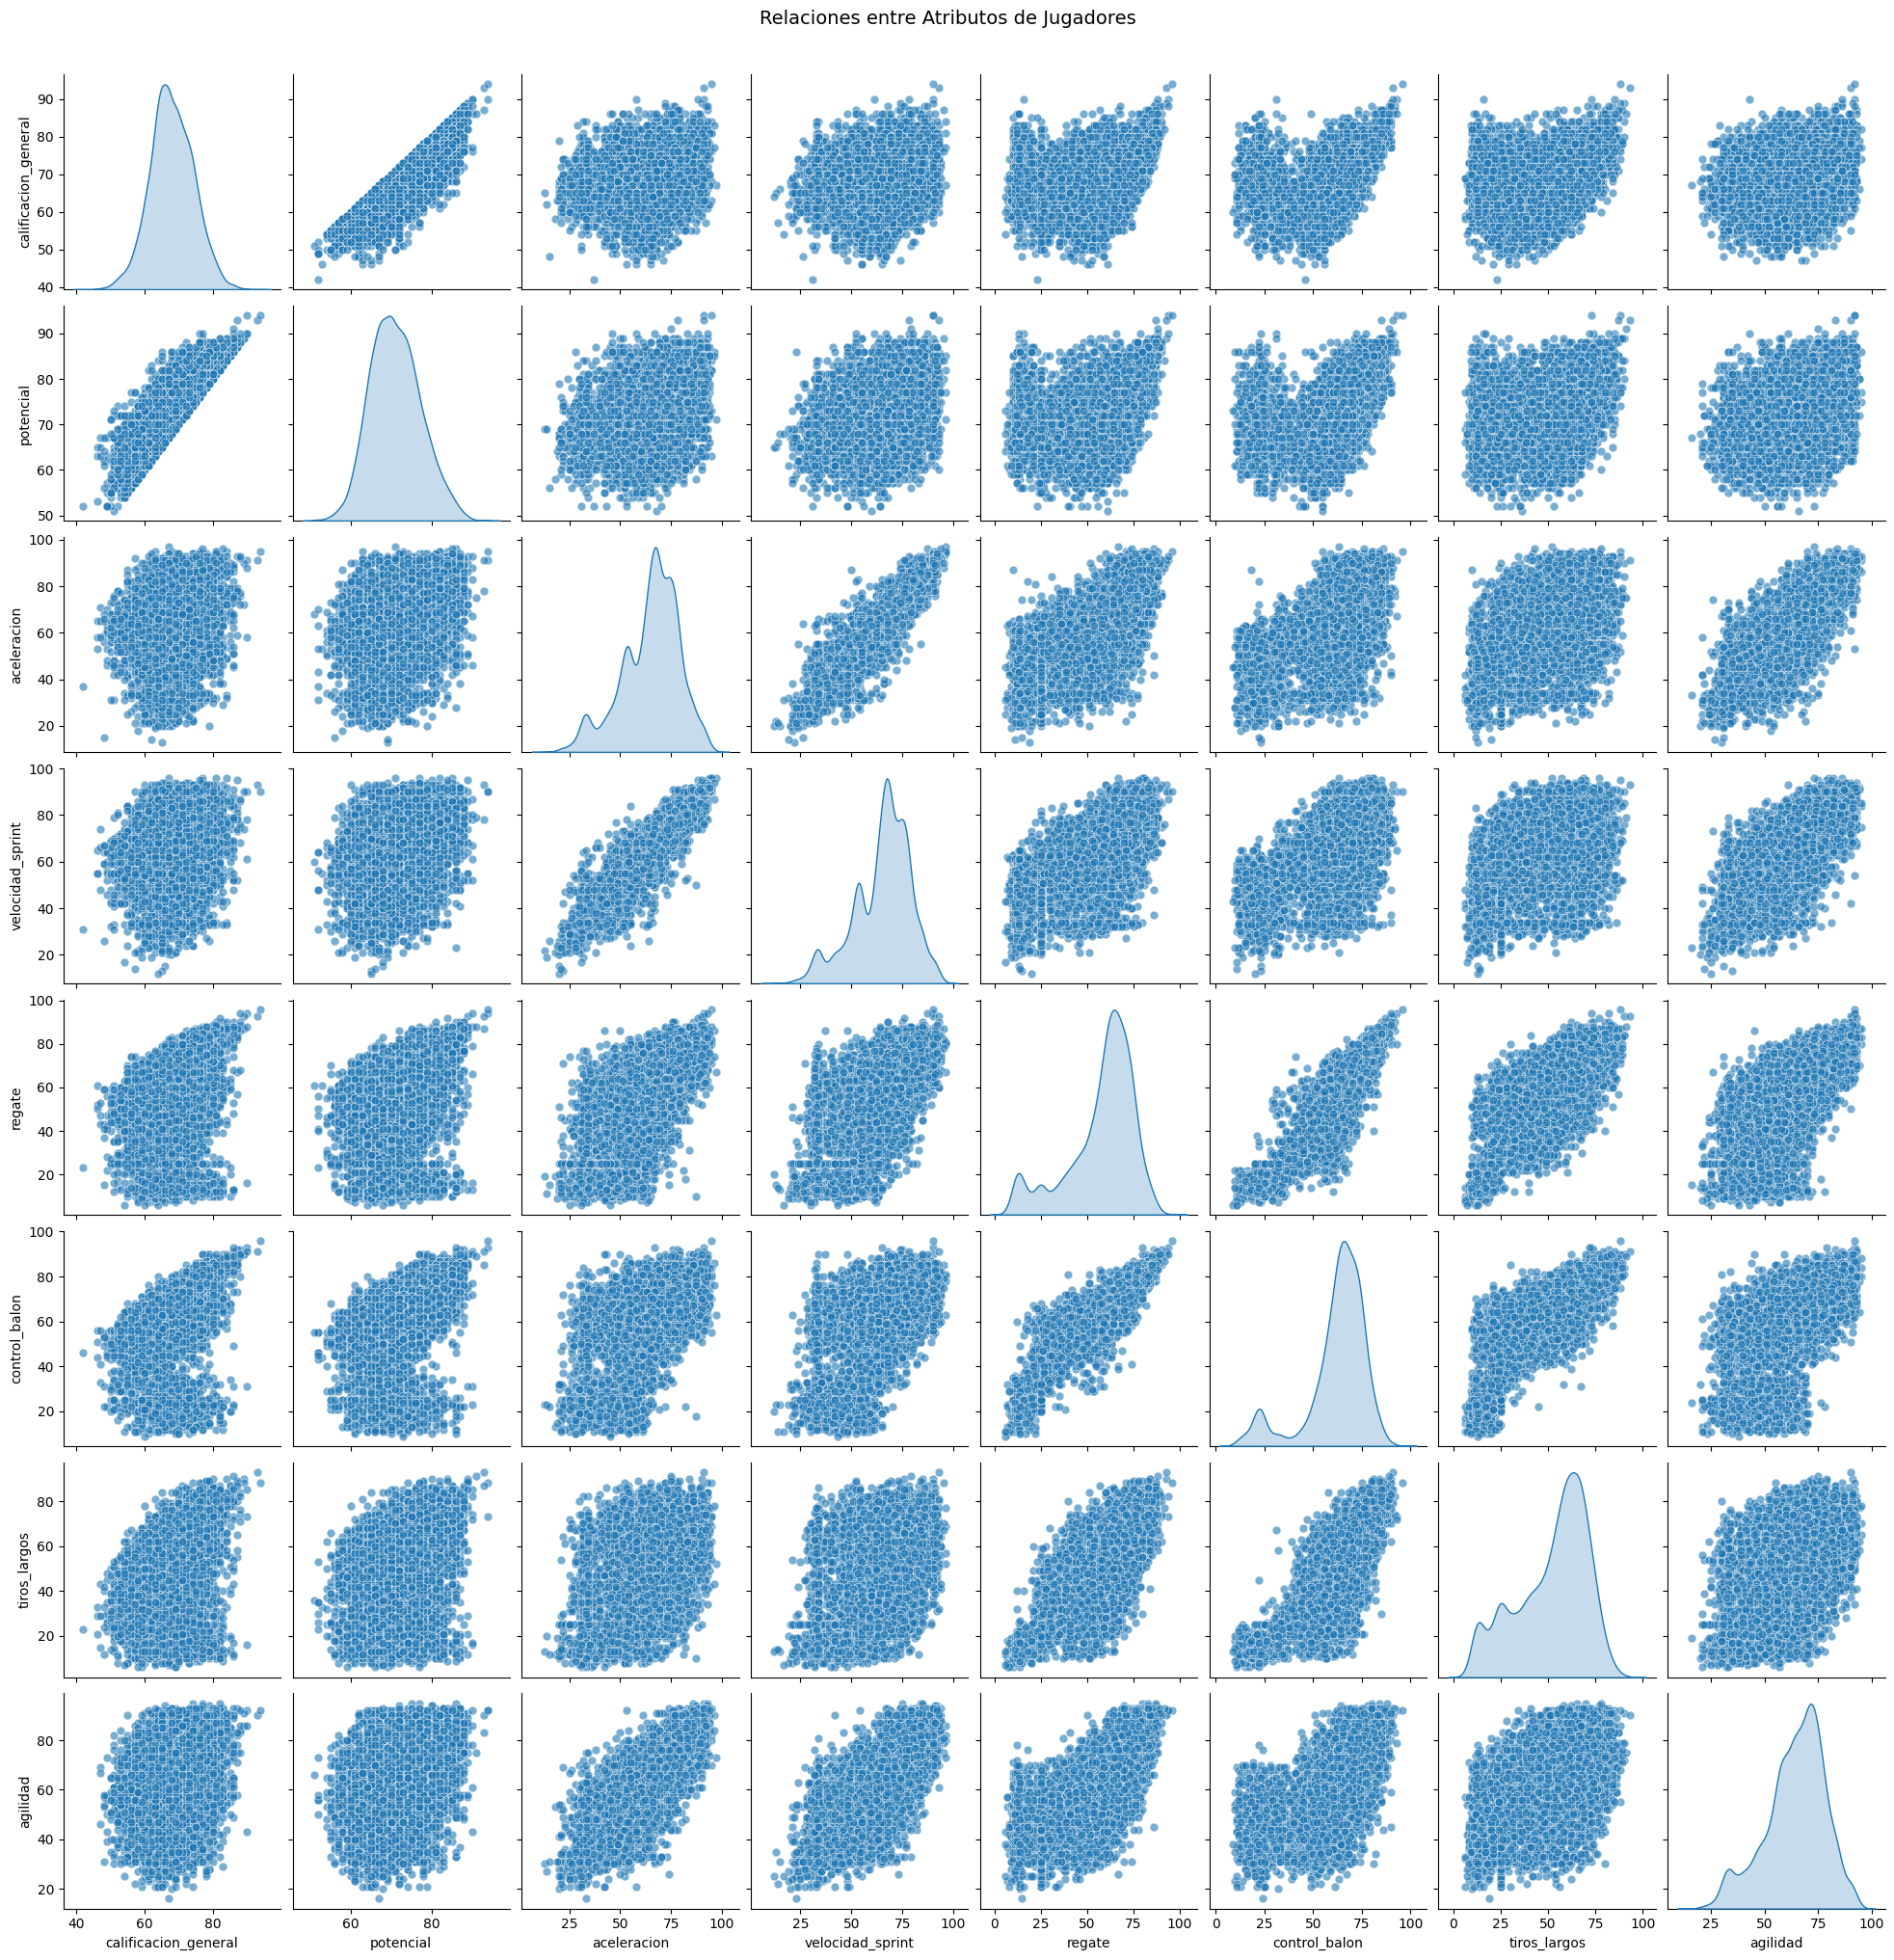

In [36]:
vars_principales = [
            'calificacion_general',
            'potencial',
            'aceleracion',
            'velocidad_sprint',
            'regate',
            'control_balon',
            'tiros_largos',
            'agilidad'
        ]

fig_pair = sns.pairplot(
            df_jugadores_stats[vars_principales],
            diag_kind="kde",
            plot_kws={'alpha': 0.6, 's': 40}
        )

        # Ajustar título general del gráfico
fig_pair.fig.suptitle(
            "Relaciones entre Atributos de Jugadores",
            y=1.02,
            fontsize=14
        )


# Predicción de la Calificación General de Jugadores a partir de sus Atributos Técnicos, Físicos y Demográficos

El objetivo del modelo es predecir la calificación general (calificacion_general) de un jugador utilizando como variables explicativas sus características técnicas (como regate, control del balón, tiros largos, velocidad, aceleración), físicas (altura, peso, edad, pie preferido y rango de edad).

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [39]:
# Se seleccionan las variables numéricas y categóricas
variables_numericas = [
    'edad', 'altura', 'peso', 'potencial', 'aceleracion', 'velocidad_sprint',
    'regate', 'agilidad', 'control_balon', 'tiros_largos', 'potencia_tiro',
    'penaltis', 'voleas', 'portero_salto', 'portero_manejo',
    'portero_patada', 'portero_posicionamiento', 'portero_reflejos'
]

variables_categoricas = ['pie_preferido', 'rango_edad']

# Se eliminan las filas con valores faltantes en las columnas relevantes
df_modelo = df_jugadores_stats.dropna(subset=variables_numericas + variables_categoricas + ['calificacion_general']).copy()

# Se crean variables dummies
df_modelo = pd.get_dummies(df_modelo, columns=variables_categoricas, drop_first=True)

# Se definen X (features) e y (target)
X = df_modelo.drop(columns=['id_jugador', 'nombre_jugador', 'fecha_temporada', 'calificacion_general'])
y = df_modelo['calificacion_general']


# SEPARAR ENTRENAMIENTO Y PRUEBA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}")
print(f"Tamaño de prueba: {X_test.shape}")

Tamaño de entrenamiento: (8462, 22)
Tamaño de prueba: (2116, 22)


In [40]:
dt_model = DecisionTreeRegressor(random_state=42)
dt_params = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(dt_model, dt_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
dt_grid.fit(X_train, y_train)

dt_best_model = dt_grid.best_estimator_
dt_rmse = np.sqrt(-dt_grid.best_score_)
print(f"RMSE Decision Tree (CV): {dt_rmse:.3f}")
print(f"Mejores hiperparámetros: {dt_grid.best_params_}")

# ---- Random Forest ----
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)

rf_best_model = rf_grid.best_estimator_
rf_rmse = np.sqrt(-rf_grid.best_score_)
print(f"RMSE Random Forest (CV): {rf_rmse:.3f}")
print(f"Mejores hiperparámetros: {rf_grid.best_params_}")


# SELECCIÓN DEL MEJOR MODELO
if rf_rmse < dt_rmse:
    best_model = rf_best_model
    best_name = "Random Forest"
    best_rmse = rf_rmse
else:
    best_model = dt_best_model
    best_name = "Decision Tree"
    best_rmse = dt_rmse

print(f"\nMejor modelo: {best_name} con RMSE = {best_rmse:.3f}")

RMSE Decision Tree (CV): 2.106
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
RMSE Random Forest (CV): 1.746
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

Mejor modelo: Random Forest con RMSE = 1.746


In [41]:
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("\n Importancia de atributos:")
    for i in range(len(X_train.columns)):
        print(f"{i+1}. {X_train.columns[indices[i]]}: {importances[indices[i]]:.4f}")


 Importancia de atributos:
1. potencial: 0.6895
2. edad: 0.2218
3. rango_edad_20-25: 0.0144
4. control_balon: 0.0137
5. potencia_tiro: 0.0054
6. peso: 0.0046
7. tiros_largos: 0.0044
8. voleas: 0.0044
9. penaltis: 0.0041
10. regate: 0.0041
11. agilidad: 0.0037
12. portero_posicionamiento: 0.0036
13. portero_patada: 0.0036
14. portero_reflejos: 0.0036
15. altura: 0.0035
16. velocidad_sprint: 0.0035
17. portero_manejo: 0.0035
18. portero_salto: 0.0034
19. aceleracion: 0.0033
20. rango_edad_25-30: 0.0012
21. pie_preferido_zurdo: 0.0006
22. rango_edad_30 o +: 0.0001


El modelo de Random Forest resultó ser el mejor para predecir la calificación general de los jugadores, alcanzando un RMSE de 1.746, lo que indica una muy buena capacidad predictiva considerando la escala de las variables. Entre las variables más influyentes se destacan “potencial” y “edad”, que en conjunto explican la mayor parte de la variabilidad en la calificación general. Esto sugiere que el desempeño actual de un jugador está fuertemente determinado por su potencial proyectado y su edad, lo cual tiene sentido desde una perspectiva deportiva: los jugadores más jóvenes con alto potencial tienden a tener calificaciones más altas o en crecimiento, mientras que los jugadores mayores suelen estabilizar su rendimiento.

Por otro lado, variables técnicas como “control de balón”, “potencia de tiro”, “tiros largos”, “regate” y “agilidad” también contribuyen, aunque en menor medida, a explicar la calificación general, indicando que las habilidades técnicas siguen siendo relevantes pero no determinantes frente al potencial y la edad. Las variables categóricas transformadas en dummies, como el rango de edad y el pie preferido, mostraron una importancia muy baja, lo que sugiere que, en este conjunto de datos, estos factores no tienen un impacto significativo sobre la valoración general del jugador. En conjunto, el modelo evidencia que las características físicas y técnicas influyen, pero el potencial sigue siendo el principal indicador del rendimiento global.

Los hiperparámetros óptimos seleccionados para el modelo de Random Forest reflejan un equilibrio entre la complejidad del modelo y su capacidad de generalización. El valor de max_depth=None indica que los árboles no tienen una profundidad máxima predefinida, lo que les permite crecer hasta que todas las hojas sean puras o contengan menos del número mínimo de muestras indicado. Esto sugiere que el modelo se ajustó para capturar relaciones complejas entre las variables sin imponer una restricción artificial sobre la profundidad, confiando en los otros parámetros para evitar el sobreajuste.

Por otro lado, los valores min_samples_split=2 y min_samples_leaf=2 permiten que los árboles se dividan con relativa facilidad, lo que incrementa su nivel de detalle y capacidad para representar patrones específicos en los datos, aunque evitando hojas con una sola observación (lo que reduce el riesgo de ruido). Finalmente, el parámetro n_estimators=200 indica que el modelo utiliza 200 árboles en el bosque, lo que mejora la estabilidad y precisión del modelo al promediar múltiples estimaciones. En conjunto, estos hiperparámetros sugieren un modelo robusto y flexible, con una estructura suficientemente compleja para capturar relaciones no lineales, pero sin perder capacidad de generalización